In [1]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join

from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import to_tree

from collections import Counter
from numpy.random import random

from matplotlib import pyplot as plt

from cycler import cycler
import matplotlib as mpl

import ete3
from kneed import KneeLocator

Configuration
Define directory, knee sensitivity, and ground truth

In [2]:
directory = "Per37_Best"
S_set = [4, 8, 16, 32, 64]
choice = -2
search = "full"

groundTruth = {'G':'1-1-1',
               'O':'1-1-2',
               'K':'1-2-1',
               'I':'1-2-2',
               'N':'2-1-1',
               'B':'2-1-2',
               'M':'2-2-1',
               'D':'2-2-2',
               'A':'3-1-1',
               'F':'3-1-2',
               'J':'3-2-1',
               'P':'3-2-2',
               'L':'4-1-1',
               'C':'4-1-2',
               'E':'4-2-1',
               'H':'4-2-2'}
trueNewick = '(((4-2-2,4-2-1),(4-1-1,4-1-2)),(3-1-2,3-1-1),((1-2-1,1-2-2),1-1-1),((2-1-1,2-1-2),(2-2-1,2-2-2)));'
trueTree = ete3.Tree(trueNewick)
print(trueTree)


         /-4-2-2
      /-|
     |   \-4-2-1
   /-|
  |  |   /-4-1-1
  |   \-|
  |      \-4-1-2
  |
  |   /-3-1-2
  |--|
  |   \-3-1-1
  |
--|      /-1-2-1
  |   /-|
  |--|   \-1-2-2
  |  |
  |   \-1-1-1
  |
  |      /-2-1-1
  |   /-|
  |  |   \-2-1-2
   \-|
     |   /-2-2-1
      \-|
         \-2-2-2


Define Figure Plotting Settings

In [3]:
colors = ['#1f77b4', 
         '#ff3f3f',
         '#3f9f3f',
         '#3f3f3f',
         '#ce3fce',
         '#3fcece']

mpl.rcParams['axes.prop_cycle'] = cycler(color=colors)

These are functions needed to perform computations

In [4]:
### Generalized Jaccard Similarity
# Given 2 counters, compute the generalized jaccard similarity
def GJS(A, B):
    union = set(A.keys()).union(set(B.keys()))
    num = 0
    den = 0
    for element in union:
        num += min(A[element], B[element])
        den += max(A[element], B[element])
    return num/den

### Jaccard Similarity on sets
# Given 2 arrays, compute the jaccard similiarty
def JS(A, B):
    intersect = set(A).intersection(set(B))
    union = set(A).union(set(B))
    return len(intersect)/len(union)

### Signature to Multiset
# Given a list of signatures, return a counter where each substring
# is added as an element of a multiset contributing 1/length to the
# count.
def SM(signatures):
    multiset = Counter({})
    for string in signatures:
        length = len(string)
        for i in range(length):
            multiset[string[0:i+1]] += 1/length
    return multiset

### Obscure Signatures
# Given a list of signatures.  
# Keep is the proportion of 
def mask(array, keep, seed=0):
    np.random.seed(seed)
    mask = np.full(len(array), False)
    mask[:int(len(array) * keep + 1)] = True
    np.random.shuffle(mask)
    return array[mask]

### Compute pairwise Partial Tree Jaccard Distances
# Given an ordering of well data (IDlist) and the well data (wellData)
# compute the pairwise distance matrix using Partial Tree Jaccard
def PTJ(IDlist, wellData):
    n = len(IDlist)
    multisets = []
    for ID in IDlist:
        multisets.append(SM(wellData[ID]))
    
    pairwise_distance = np.ones([n, n])
    for i in range(1, n):
        for j in range(i):
            d = GJS(multisets[i], multisets[j])
            pairwise_distance[i, j] = d
            pairwise_distance[j, i] = d
    return pairwise_distance

### Compute pairwise jaccard Distances
# Given an ordering of well data (IDlist) and the well data (wellData)
# compute the pairwise distance matrix using Jaccard similarity
def Jaccard(IDlist, wellData):
    n = len(IDlist)
    pairwise_distance = np.ones([n, n])
    for i in range(1, n):
        for j in range(i):
            d = JS(wellData[IDlist[i]], wellData[IDlist[j]])
            pairwise_distance[i, j] = d
            pairwise_distance[j, i] = d
    return pairwise_distance



Importing Signatures into function by directory.  This will import every csv into memory, perform the kneedle algorithm for filtering, then generates a numpy array of strings.  This will output an ordering of file IDs, a dictionary of filtered data, and a plot showing the knee plots  

The file format should be:

signatures | length | counts | family

with name of format (IDname)_(rest of name).csv

A knee point: 433
B knee point: 460
C knee point: 441
D knee point: 409
E knee point: 416
F knee point: 560
G knee point: 573
H knee point: 270
I knee point: 266
K knee point: 322
L knee point: 513
M knee point: 425
N knee point: 395


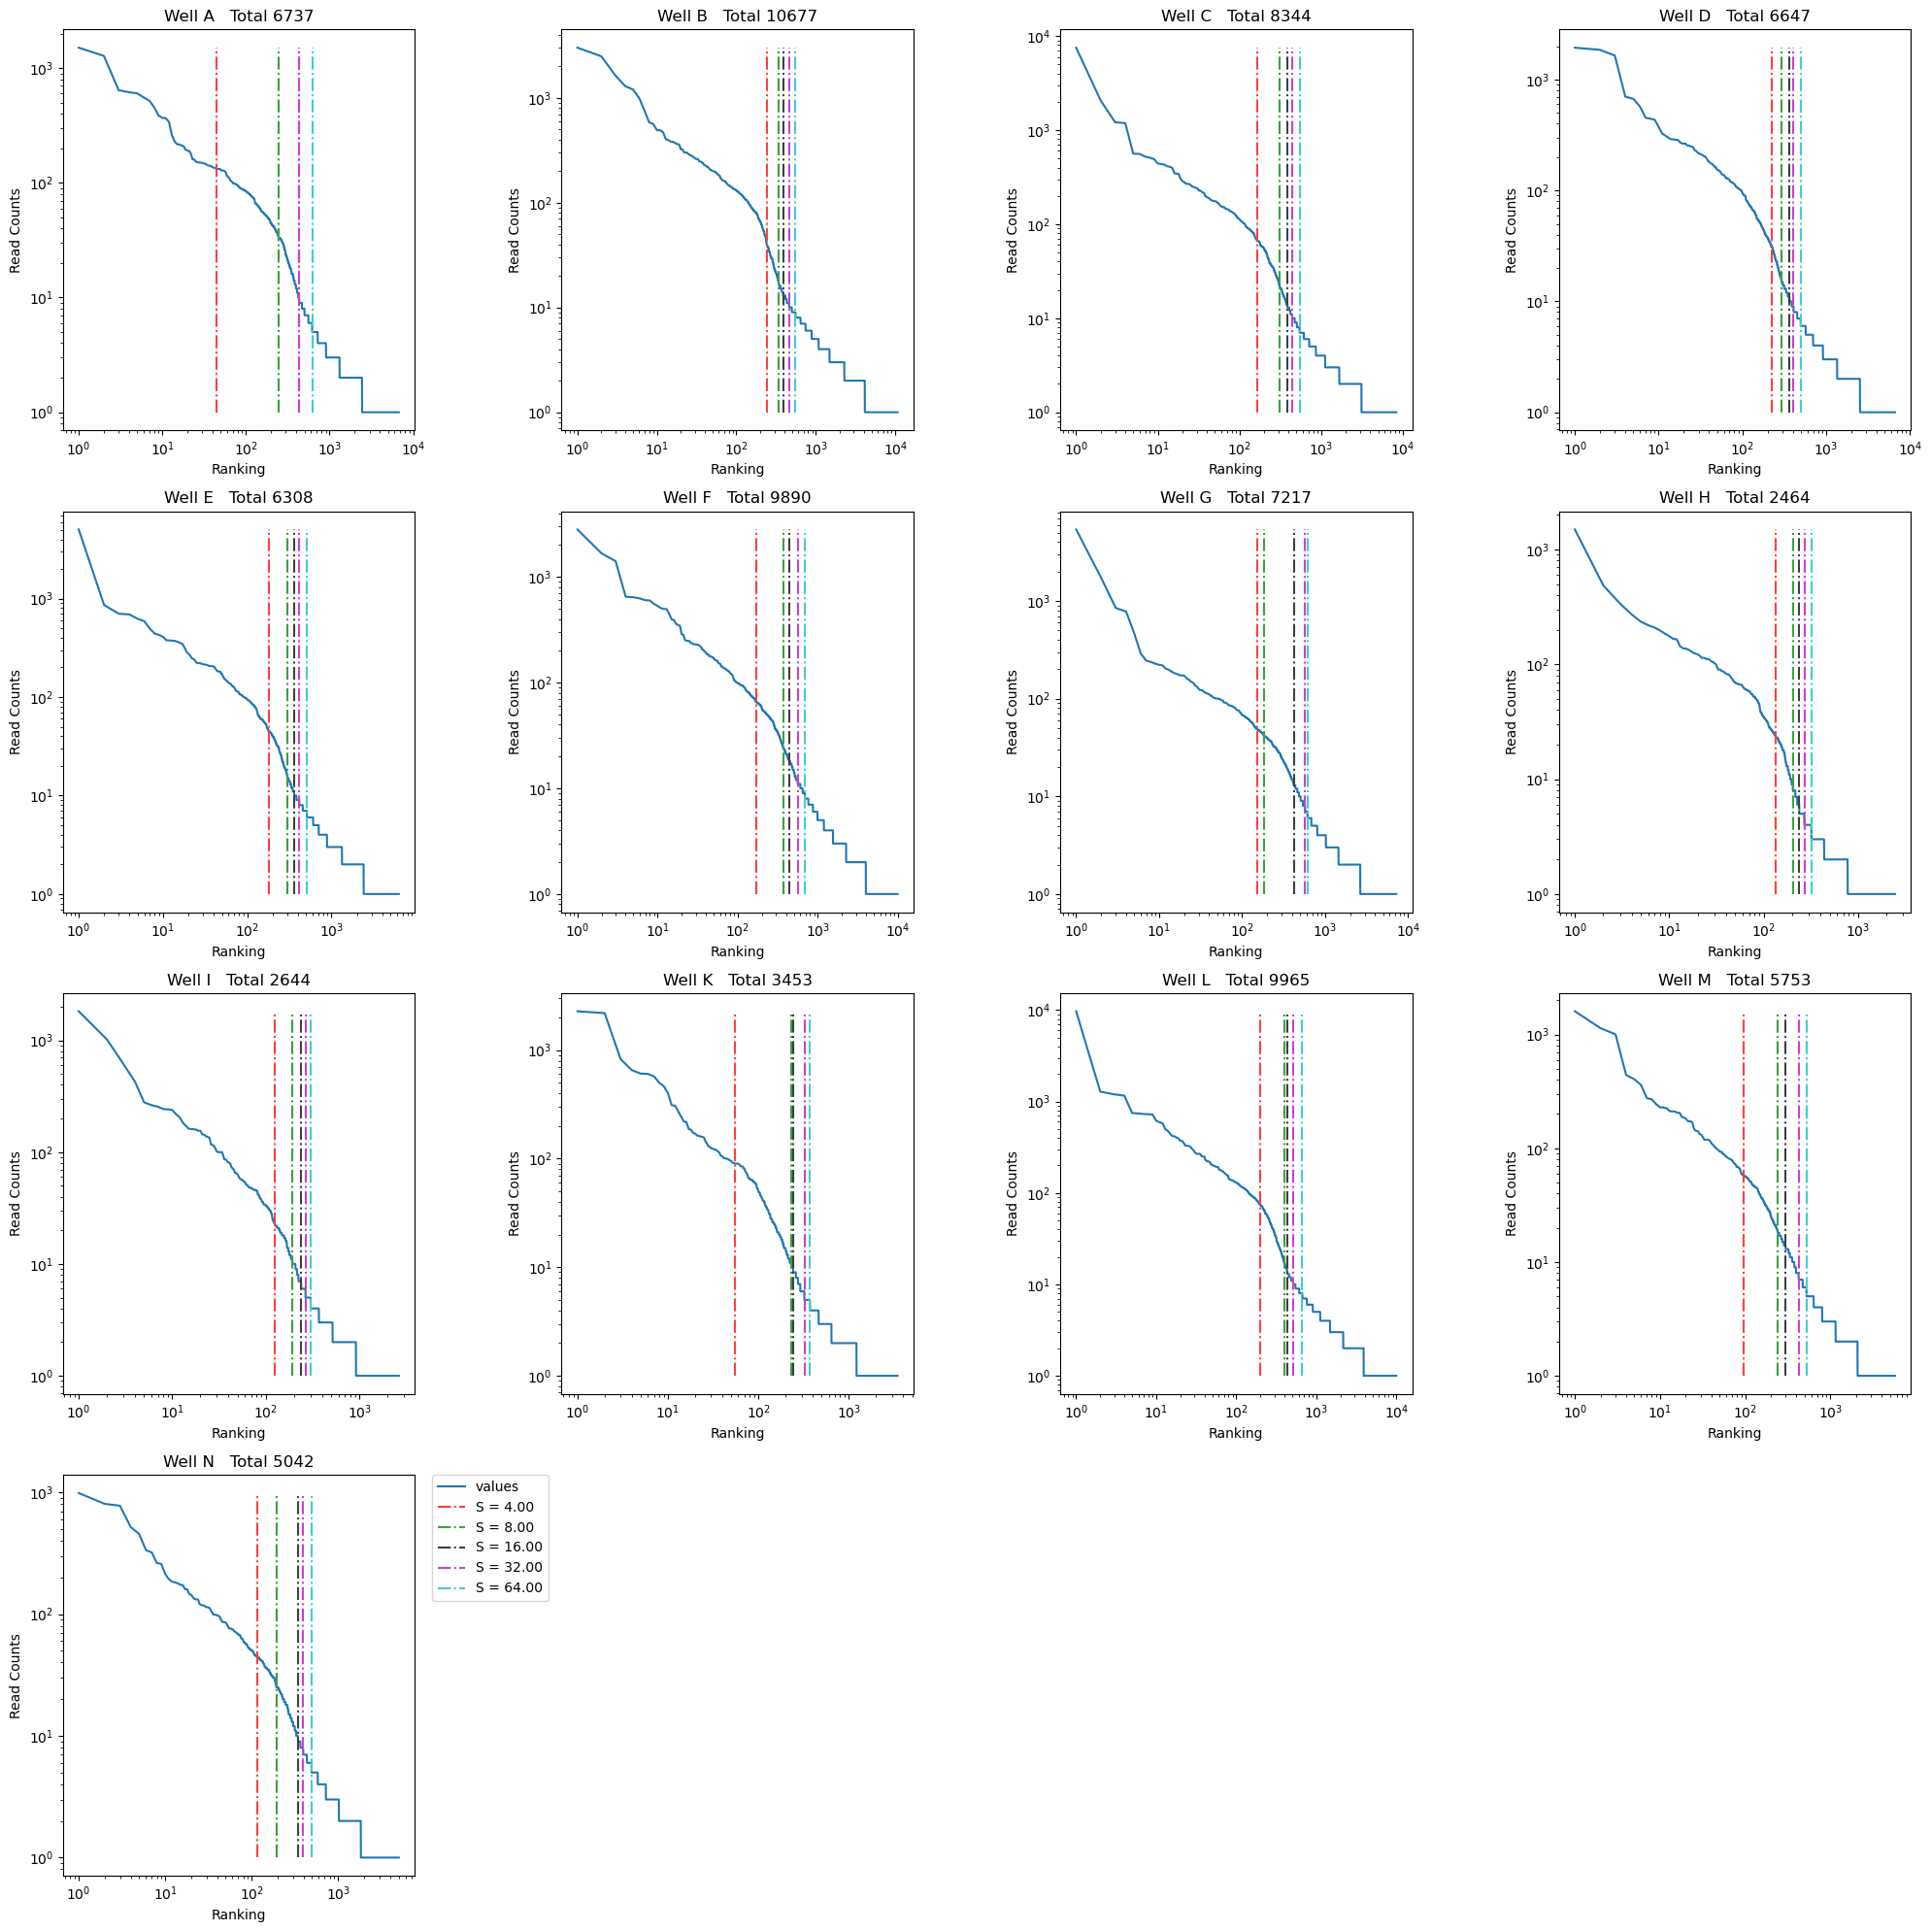

,signatures (1 letter),length,counts,Unnamed: 3
0,"""",1,124121,A
1,"""""",2,1,A
2,"""#",2,1,A
3,"""$",2,1,A
4,"""$Q",3,3,A
...,...,...,...,...
11917,^^(,3,2,A
11918,^^F,3,1,A
11919,^^I,3,2,A
11920,^^Q,3,1,A


In [5]:
csvFiles = [f for f in listdir(directory) if isfile(join(directory, f))]

IDlist = []
outputs = {}

n = len(csvFiles)
s = int(np.ceil(np.sqrt(n)))

fig, kneePlots = plt.subplots(nrows=s, ncols=s)
fig.set_size_inches(5 * s, 5 * s)
legend = ['values']

for idx, file in enumerate(csvFiles):
    filename = join(directory, file)
    idstop = file.find(search)
    ID = file[0:idstop]
    
    data = pd.read_csv(filename)
    colname = data.columns[2]
    data = data[data.iloc[:, 1] > 3]
    data = data.sort_values(by=[colname], ascending=False)
    
    # Using Kneedle Algorithm to Filter signatures
    counts = data.iloc[:, 2]
    rank = np.arange(len(counts))+1
    #locate all knees in given set
    knees = []
    for sensitivity in S_set:
        kneedle = KneeLocator(rank, counts, S=sensitivity,
                             curve='convex', direction = 'decreasing')
        knees.append(int(kneedle.knee))
        legend.append("S = %2.2f" % sensitivity)
    print("%s knee point: %d" %(ID, knees[choice]))
    knee = knees[choice]
    ax = kneePlots[idx//s, idx % s]
    
    #Knee Plot Lines
    ax.plot(rank, counts)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title("Well %s   Total %d" % (ID, len(counts)))
    ax.set_xlabel("Ranking")
    ax.set_ylabel("Read Counts")
    for knee in knees:
        ax.plot([knee, knee], [min(counts), max(counts)], linestyle='-.')
    #kneedle.plot_knee()
    
    sigs = np.array(data.iloc[:knee, 0])
    outputs[ID] = sigs
    IDlist.append(ID)
    
ax.legend(legend, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
for i in range(idx+1, s * s):
    fig.delaxes(kneePlots[i//s, i%s])
    i += 1
    
fig.tight_layout()

plt.show()
# Pretty Printing pandas database of first csv file
pd.read_csv(join(directory, csvFiles[0]))

Compute the best reconstruction using both PTJ and regular Jaccard

In [6]:
### Plot dendrograms given a title and a distance
# This function is for consistent plotting of dendrograms generated
# from computed distance matrices
def dendrogram_plot(title, distance, truth, figsize=(6,3)):
    plt.figure(figsize=figsize)
    Z = linkage(distance, 'ward')
    ptj_plot = dendrogram(Z, color_threshold=0, above_threshold_color='k', labels=truth)
    ax = plt.gca()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_ylim(0, 2)
    plt.title(title)

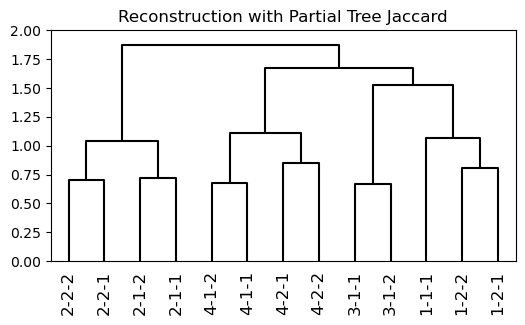

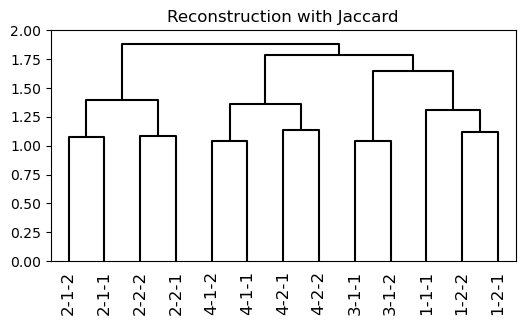

In [7]:
truth = []
for ID in IDlist:
    truth.append(groundTruth[ID])
jacDist = Jaccard(IDlist, outputs)
ptjDist = PTJ(IDlist, outputs)

dendrogram_plot("Reconstruction with Partial Tree Jaccard", ptjDist, truth)
dendrogram_plot("Reconstruction with Jaccard", jacDist, truth)

In [8]:
Z = linkage(ptjDist, 'average')
T = to_tree(Z)
### Recursive method to get newick tree taken from MrTomRod
# https://stackoverflow.com/questions/28222179/save-dendrogram-to-newick-format/31878514#31878514
def getNewick(node, newick, parentdist, leaf_names):
    if node.is_leaf():
        return "%s:%.2f%s" % (leaf_names[node.id], parentdist - node.dist, newick)
    else:
        if len(newick) > 0:
            newick = "):%.2f%s" % (parentdist - node.dist, newick)
        else:
            newick = ");"
        newick = getNewick(node.get_left(), newick, node.dist, leaf_names)
        newick = getNewick(node.get_right(), ",%s" % (newick), node.dist, leaf_names)
        newick = "(%s" % (newick)
        return newick

A =  getNewick(T, "", T.dist, truth)
t = ete3.Tree(A)
rf = trueTree.compare(t, unrooted=True)
#print(rf)

In [11]:
seeds = 4 # Set to 1000 for paper. Reduced so will run in reasonable time

jac_scores = []
ptj_scores = []

keeps = []


for keep in range(5, 99):
    keeps.append(keep)
    rf_jac = np.zeros(seeds)
    rf_ptj = np.zeros(seeds)
    for i, seed in enumerate(range(seeds)):
        
        # Obtain all masked datasets
        masked = {}
        for ID in IDlist:
            masked[ID] = mask(outputs[ID], keep/100, seed)
        
        # Build all trees
        jacDist = Jaccard(IDlist, masked)
        ptjDist = PTJ(IDlist, masked)
        jac_t = to_tree(linkage(jacDist, 'ward'))
        ptj_t = to_tree(linkage(ptjDist, 'ward'))
        
        jac_tree = ete3.Tree(getNewick(jac_t, '', jac_t.dist, truth))
        ptj_tree = ete3.Tree(getNewick(ptj_t, '', ptj_t.dist, truth))
        
        rf_jac[i] = trueTree.compare(jac_tree, unrooted=True)['rf']
        rf_ptj[i] = trueTree.compare(ptj_tree, unrooted=True)['rf']
        
    jac_scores.append(np.mean(rf_jac))
    ptj_scores.append(np.mean(rf_ptj))

(20.0, 0.0)

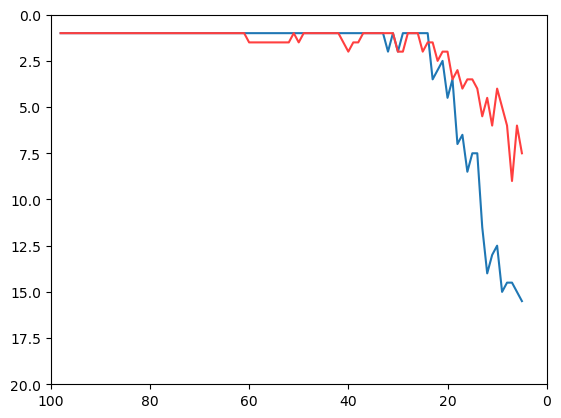

In [12]:
plt.plot(keeps, jac_scores)
plt.plot(keeps, ptj_scores)
plt.xlim([100, 0])
plt.ylim([20, 0])